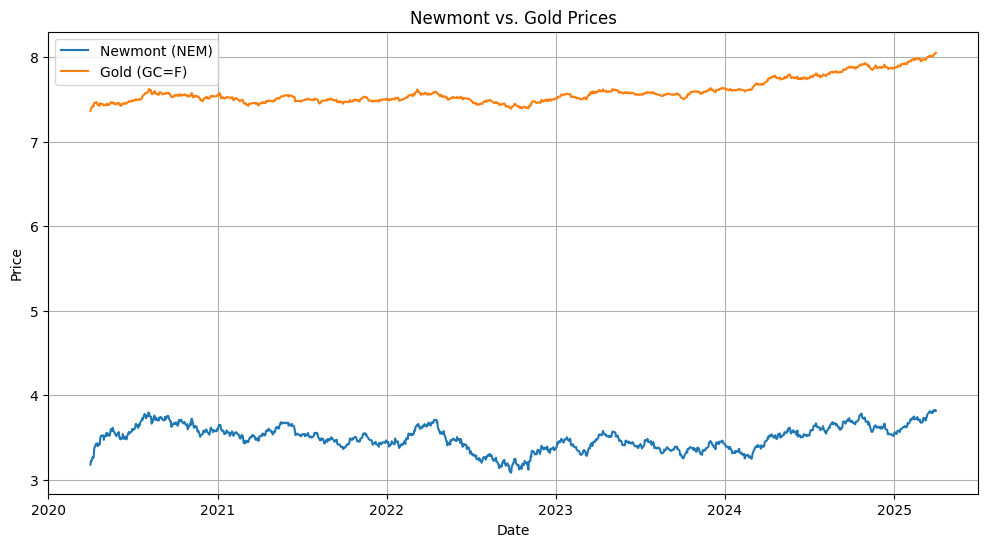


Stationarity Tests:
Newmont: p-value = 0.1287
Newmont is NOT stationary. Differencing needed.
Gold: p-value = 0.9983
Gold is NOT stationary. Differencing needed.


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

<Figure size 1200x600 with 0 Axes>

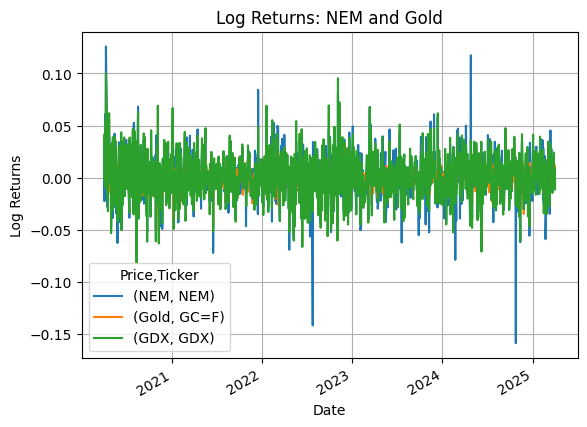

In [19]:

# Plot raw prices
plt.figure(figsize=(12, 6))
plt.plot(data.index, np.log(data['GDX']), label='Newmont (NEM)')
plt.plot(data.index, np.log(data['Gold']), label='Gold (GC=F)')
plt.title("Newmont vs. Gold Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

# Stationarity check
def check_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f"{name}: p-value = {result[1]:.4f}")
    if result[1] > 0.05:
        print(f"{name} is NOT stationary. Differencing needed.")
    else:
        print(f"{name} is stationary.")

print("\nStationarity Tests:")
check_stationarity(data['GDX'], "Newmont")
check_stationarity(data['Gold'], "Gold")

# Log returns
data_diff = np.log(data).diff().dropna()

# Plot returns
plt.figure(figsize=(12, 6))
data_diff.plot(title="Log Returns: NEM and Gold")
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.grid()
plt


In [54]:
# VAR Analysis of Gold, Newmont (NEM), and GDX

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.api import VAR

# Minimalist plot style
plt.rcParams.update({
    "font.family": "serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True
})

# --- Load Data ---
def get_data():
    start_date = datetime.now() - pd.DateOffset(years=5)
    end_date = datetime.now()

    nem = yf.download('NEM', start=start_date, end=end_date, auto_adjust=False)[['Close']]
    gold = yf.download('GC=F', start=start_date, end=end_date, auto_adjust=False)[['Close']]
    gdx = yf.download('GDX', start=start_date, end=end_date, auto_adjust=False)[['Close']]

    # Rename columns before concatenation
    nem.columns = ['NEM']
    gold.columns = ['Gold']
    gdx.columns = ['GDX']

    df = pd.concat([nem, gold, gdx], axis=1).dropna()
    return df
df=get_data()
# --- Monthly Log Returns ---
monthly_data = df.resample('ME').mean()
monthly_log_returns = np.log(monthly_data).diff().dropna()

# --- ADF Stationarity Tests ---
def check_stationarity(series, name):
    result = adfuller(series)
    print(f"{name}: p-value = {result[1]:.4f}")
    print(f"{name} is {'stationary' if result[1] <= 0.05 else 'NOT stationary'}.")

print("\nMonthly Stationarity Tests:")
for col in monthly_log_returns.columns:
    check_stationarity(monthly_log_returns[col], col)

# --- Granger Causality Test: Gold → GDX ---
print("\nGranger Causality Test (Gold → GDX):")
grangercausalitytests(monthly_log_returns[['GDX', 'Gold']], maxlag=3, verbose=True)

# --- Fit VAR Model ---
model = VAR(monthly_log_returns)
lag_selection = model.select_order(12)
selected_lag = lag_selection.aic
fitted_model = model.fit(selected_lag)

print("\nVAR Model Summary:")
print(fitted_model.summary())

# --- IRF: Gold → GDX ---
irf = fitted_model.irf(12)
fig = irf.plot(impulse='Gold', response='GDX')
plt.suptitle("Impulse Response: Monthly Gold Shock → GDX", fontsize=14)
plt.tight_layout()
plt.savefig("irf_gold_to_gdx.png")
plt.close()

# --- Forecast Error Variance Decomposition ---
fevd = fitted_model.fevd(12)

def plot_fevd_stacked(fevd, target_var, filename):
    idx = fitted_model.names.index(target_var)
    decomp = fevd.decomp[:, idx, :]
    months = np.arange(1, decomp.shape[0] + 1)

    plt.figure(figsize=(10, 6))
    plt.stackplot(months, decomp.T, labels=fitted_model.names)
    plt.title(f"FEVD - Stacked Area Chart: {target_var}")
    plt.xlabel("Months Ahead")
    plt.ylabel("Fraction of Variance")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

plot_fevd_stacked(fevd, 'GDX', "fevd_gdx.png")
plot_fevd_stacked(fevd, 'Gold', "fevd_gold.png")
plot_fevd_stacked(fevd, 'NEM', "fevd_nem.png")

# --- Cumulative IRFs: Shock to Gold ---
orth_irfs = irf.orth_irfs
cumulative_irfs = np.cumsum(orth_irfs, axis=0)
months = np.arange(1, cumulative_irfs.shape[0] + 1)
impulse_idx = fitted_model.names.index('Gold')

for i, response_var in enumerate(fitted_model.names):
    plt.figure(figsize=(10, 6))
    plt.plot(months, cumulative_irfs[:, i, impulse_idx], label=f"Gold → {response_var}", color='blue')
    plt.axhline(0, linestyle='--', linewidth=0.7, color='black')
    plt.title(f"Cumulative IRF: Shock to Gold → {response_var}")
    plt.xlabel("Months Ahead")
    plt.ylabel("Cumulative Response")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"cumulative_irf_gold_to_{response_var.lower()}.png")
    plt.close()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Monthly Stationarity Tests:
NEM: p-value = 0.0002
NEM is stationary.
Gold: p-value = 0.0000
Gold is stationary.
GDX: p-value = 0.0000
GDX is stationary.

Granger Causality Test (Gold → GDX):

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7419  , p=0.3927  , df_denom=56, df_num=1
ssr based chi2 test:   chi2=0.7816  , p=0.3766  , df=1
likelihood ratio test: chi2=0.7765  , p=0.3782  , df=1
parameter F test:         F=0.7419  , p=0.3927  , df_denom=56, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3541  , p=0.2670  , df_denom=53, df_num=2
ssr based chi2 test:   chi2=2.9638  , p=0.2272  , df=2
likelihood ratio test: chi2=2.8905  , p=0.2357  , df=2
parameter F test:         F=1.3541  , p=0.2670  , df_denom=53, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2225  , p=0.8803  , df_denom=50, df_num=3
ssr based chi2 test:   chi2=0.7610  , p=0.8588  , df=3
likelihood ratio test: chi2=0.7560 